## Imports and dependencies

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

## Data Pre-processing

Load the CSV file and look at the top 5 rows.

In [2]:
waiter_tips = pd.read_csv('./data/tips.csv')

In [3]:
waiter_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Check for null values or missing data.

In [4]:
waiter_tips.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Lets inspect what kind of data types we have, how many entries, and look at some statistical descriptions of our dataset.

In [5]:
waiter_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [6]:
waiter_tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


From the description we can see that have some nominal columns, such as sex, smoker, day, and time. 

Encoding of categorical values

In [7]:
ohe = OneHotEncoder(sparse=False)

In [8]:
le = LabelEncoder()

In [9]:
waiter_tips['sex'] = ohe.fit_transform(waiter_tips[['sex']])
waiter_tips['smoker'] = ohe.fit_transform(waiter_tips[['smoker']])

In [10]:
waiter_tips['day'] = le.fit_transform(waiter_tips['day'])
waiter_tips['time'] = le.fit_transform(waiter_tips['time'])

In [11]:
waiter_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,1.0,1.0,2,0,2
1,10.34,1.66,0.0,1.0,2,0,3
2,21.01,3.50,0.0,1.0,2,0,3
3,23.68,3.31,0.0,1.0,2,0,2
4,24.59,3.61,1.0,1.0,2,0,4


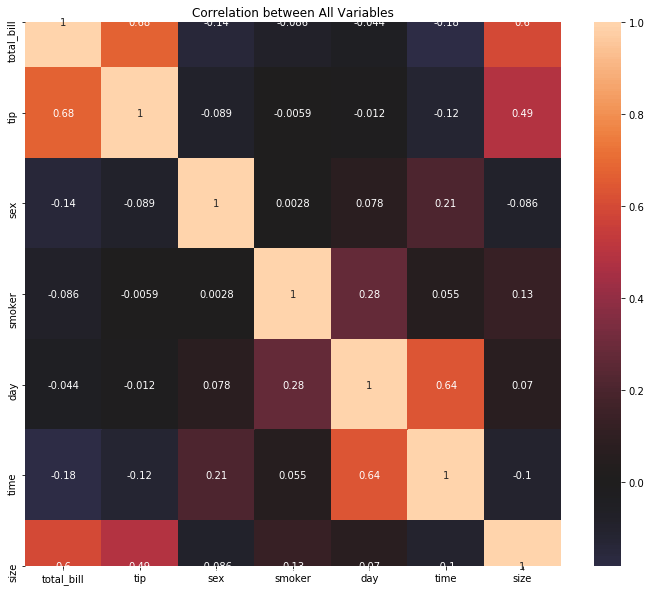

In [12]:
corr = waiter_tips.corr()
fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(corr,ax = ax, annot = True, center = 0)
ax.set_title('Correlation between All Variables')
plt.show()

We can see that there is a relatively high correlation between the following variables: 

time and day (correlation = 0.64)
tip and total_bill (correlation = 0.68)
size and tip (0.49)
size and total_bill (0.6)
and interesting negative correlations between the following
smoker and day (-0.28)
time and sex (-0.21)

So now we need to annotate our dataset based on the tip received (compared to total bill and size) as a good or bad tip.

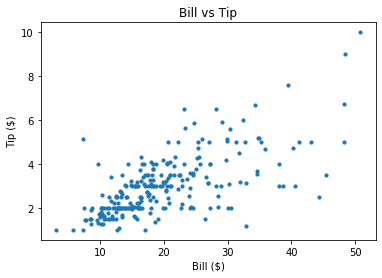

In [13]:
plt.scatter(waiter_tips['total_bill'], waiter_tips['tip'], s=10)
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

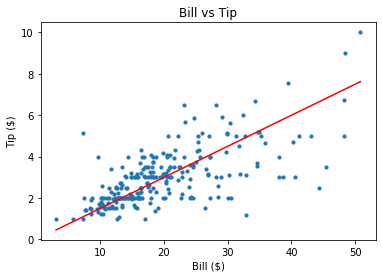

In [14]:
x0 = min(waiter_tips['total_bill'])
x1 = max(waiter_tips['total_bill'])
y0 = x0*15/100
y1 = x1*15/100

plt.scatter(waiter_tips['total_bill'], waiter_tips['tip'], s=10)
# plt.scatter(waiter_tips['total_bill'], waiter_tips['tip'], s=10)
plt.plot([x0, x1], [y0, y1], 'r')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()


So if we were to classify a tip as good or bad tips being above the red line would be good and those below would be bad. 
If a good tip meant at least 15% of the total bill.

Now we annotate our data with what our understanding of a good tip is.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4818D7088>,
      dtype=object)

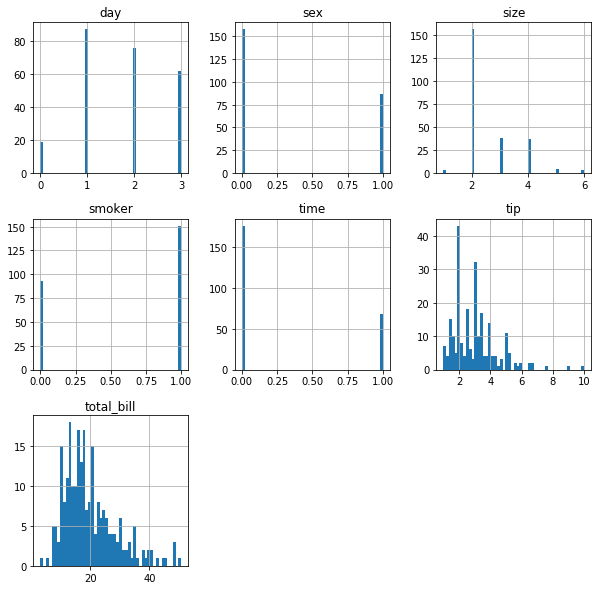

In [15]:
waiter_tips.hist(bins=50, figsize=(10,10))

We can see that most of the distributions are skewed towards the right meaning we have more samples that would be identified as good tips.

So lets add an extra column saying if the tip was good or not and this is what we will be trying to classify with our model.

In [16]:
waiter_tips['rating'] = waiter_tips.apply(lambda x: 1 if x['tip'] >= x['total_bill']*15/100 else 0, axis = 1)

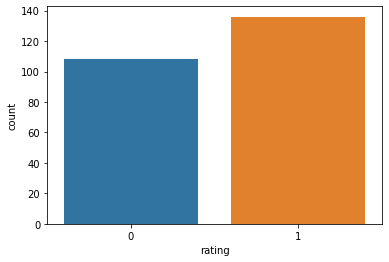

In [17]:
sns.countplot(waiter_tips['rating'])

Now that we have pre-processed the data we can split it into training and test data and apply scaling to the splits.

Scale training and test datasets.

In [18]:
# Split
y = waiter_tips['rating']
X = waiter_tips.drop(['rating'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#  Scale
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

## Models

In [19]:
models = []
models.append(('LogisticRegression', LogisticRegression(solver='lbfgs')))
models.append(('NaiveBayes', GaussianNB()))
models.append(('GradientDescent', SGDClassifier()))
models.append(('SupportVectorClassifier', SVC(gamma='scale')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100)))

In [20]:
for name,model in models:
    kfold = model_selection.StratifiedKFold(n_splits=5, random_state=2)
    results = model_selection.cross_val_score(model, X_train, y_train, cv= kfold, scoring = 'accuracy')
    msg  = "%s: %f" % (name, results.mean())
    print(msg)

LogisticRegression: 0.958824
NaiveBayes: 0.670588
GradientDescent: 0.823529
SupportVectorClassifier: 0.670588
KNN: 0.694118
DecisionTree: 0.858824
RandomForest: 0.811765


Compare to scaled version of training data.

In [21]:
for name,model in models:
    kfold = model_selection.StratifiedKFold(n_splits=5, random_state=2)
    results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv= kfold, scoring = 'accuracy')
    msg  = "%s: %f" % (name, results.mean())
    print(msg)

LogisticRegression: 0.941176
NaiveBayes: 0.670588
GradientDescent: 0.911765
SupportVectorClassifier: 0.776471
KNN: 0.717647
DecisionTree: 0.864706
RandomForest: 0.811765


Compare against null score (picking the dominating category for every new sample)

In [22]:
y_test.value_counts()

1    41
0    33
Name: rating, dtype: int64

In [23]:
y_test.mean()

0.5540540540540541

In [24]:
1 - y_test.mean()

0.44594594594594594

So if the models do not achieve at least 0.446 accuracy they would not be better than picking the dominant category every time.
All of the chosen models are better so we will select the top 4 for more detailed comparison

## Logistic Regression

In [25]:
lr = LogisticRegression()

# Define grid (possible parameter space)
grid = {'C': np.logspace(-3,3,7), 'penalty': ['l2'], 'solver': ['newton-cg', 'sag', 'lbfgs']}


lr_cv = GridSearchCV(lr, grid, cv=5)

lr_cv.fit(X_train_scaled, y_train)

C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

The score of the model (accuracy)

In [26]:
lr_cv.score(X_test_scaled, y_test)

0.8783783783783784

Lets see what the best parameters are

In [27]:
lr_cv.best_params_

{'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [28]:
lr2 = LogisticRegression(C=1000, penalty='l2', solver='newton-cg')
lr2.fit(X_train_scaled, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
lr2.score(X_test_scaled, y_test)

0.8783783783783784

Seems to be performing worse than our initial accuracy of 0.958824 so maybe the reason for the accuracy difference is in the scaling of the data.

In [30]:
lr = LogisticRegression()

# Define grid (possible parameter space)
grid = {'C': np.logspace(-3,3,7), 'penalty': ['l2'], 'max_iter': [100], 'solver': ['newton-cg', 'sag', 'lbfgs']}


lr_cv = GridSearchCV(lr, grid, cv=5)

lr_cv.fit(X_train, y_train)

C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
lr_cv.score(X_test, y_test)

0.9594594594594594

In [32]:
lr_cv.best_params_

{'C': 100.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [33]:
lr3 = LogisticRegression(C=100, penalty='l2', solver='newton-cg')

In [34]:
lr3.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
lr3.score(X_test, y_test)

0.9594594594594594

Lets look at the confusion matrix to see how our model performs on the test data compared to the ground truth.

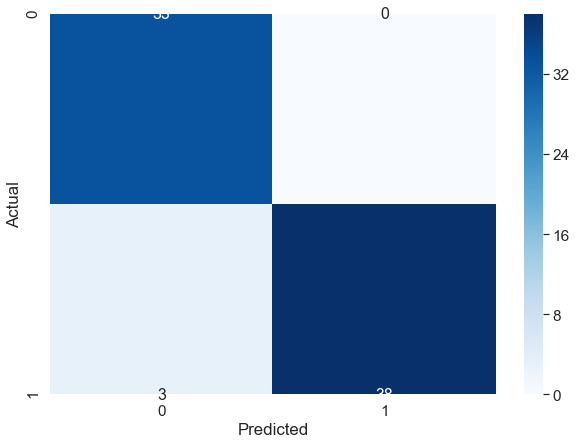

In [36]:
lr_data = confusion_matrix(y_test, lr3.predict(X_test))

lr_cm = pd.DataFrame(lr_data, columns=np.unique(y_test), index = np.unique(y_test))
lr_cm.index.name = 'Actual'
lr_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(lr_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Gradient Descent

In [37]:
gd = SGDClassifier()

# Define grid (possible parameter space)
grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['l1','l2','elasticnet'], 
        'eta0': [0.01],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
       }


gd_cv = GridSearchCV(gd, grid, cv=5)

gd_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'eta0': [0.01],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                      

In [38]:
gd_cv.score(X_test_scaled, y_test)

0.8513513513513513

In [39]:
gd_cv.best_params_

{'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l1'}

In [40]:
gd2 = SGDClassifier(eta0=0.01, learning_rate='adaptive', loss='squared_hinge', penalty='l1')

In [41]:
gd2.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='squared_hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
gd2.score(X_test_scaled, y_test)

0.8918918918918919

In [43]:
gd3 = SGDClassifier(eta0=0.01, learning_rate='adaptive', loss='squared_hinge', penalty='l1')

In [44]:
gd3.fit(X_train, y_train)

C:\Users\velit\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='squared_hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
gd3.score(X_test, y_test)

0.9594594594594594

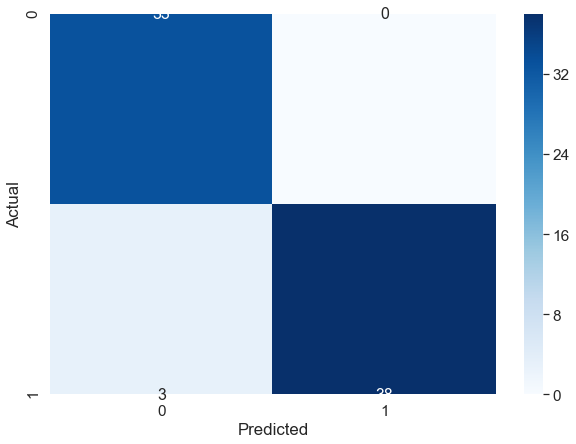

In [46]:
gd_data = confusion_matrix(y_test, gd3.predict(X_test))

gd_cm = pd.DataFrame(gd_data, columns=np.unique(y_test), index = np.unique(y_test))
gd_cm.index.name = 'Actual'
gd_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(gd_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Decision Tree

In [48]:
dt = DecisionTreeClassifier()

# Define grid (possible parameter space)
# Note running this takes some time
grid = {'criterion': ['gini', 'entropy'],
        'splitter': ['best','random'], 
        'max_depth': np.arange(1, 10,1),
        'min_samples_split': np.arange(0.1,1,0.1),
        'max_leaf_nodes': np.arange(2,10,1),
        'max_features': np.arange(1,6,1)
       }


dt_cv = GridSearchCV(dt, grid, cv=5)

dt_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
   

In [49]:
dt_cv.score(X_test_scaled, y_test)

0.7567567567567568

In [50]:
dt_cv.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 5,
 'max_leaf_nodes': 7,
 'min_samples_split': 0.2,
 'splitter': 'best'}

In [51]:
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=5, max_leaf_nodes=7, min_samples_split=0.1, splitter='best')
dt2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=5, max_leaf_nodes=7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [52]:
dt2.score(X_test_scaled, y_test)

0.8378378378378378

In [53]:
dt3 = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=5, max_leaf_nodes=7, splitter='best')
dt3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=5, max_leaf_nodes=7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [54]:
dt3.score(X_test, y_test)

0.8648648648648649

Improvement compared to scaled version of the model but only when omitting the min_samples_split parameter.

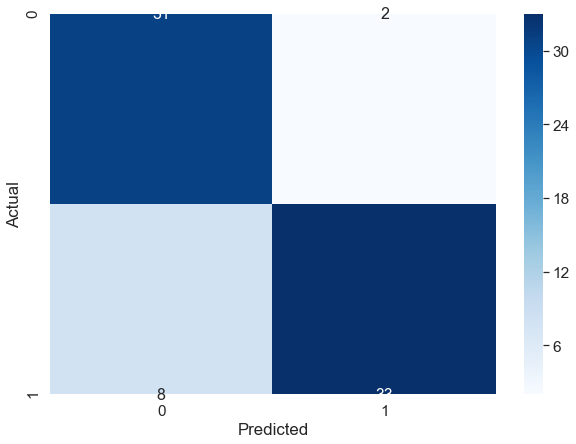

In [55]:
dt_data = confusion_matrix(y_test, dt3.predict(X_test))

dt_cm = pd.DataFrame(dt_data, columns=np.unique(y_test), index = np.unique(y_test))
dt_cm.index.name = 'Actual'
dt_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(dt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Random Forest

In [77]:
rf = RandomForestClassifier()

# Define grid (possible parameter space)
# Note running this takes more time
grid = {
        'criterion': ['gini'], #['gini', 'entropy'],
        'n_estimators': [47], #np.arange(1,50,1), 
        'max_depth': [9], #np.arange(1, 10,1),
        'min_samples_split': [0.1], # np.arange(0.1,1,0.1),
        'max_leaf_nodes': [5], #np.arange(2,10,1),
        'max_features': [5] #np.arange(1,6,1),
       }


rf_cv = GridSearchCV(rf, grid, cv=5)

rf_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [78]:
rf_cv.score(X_test_scaled, y_test)

0.8108108108108109

In [79]:
rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 5,
 'max_leaf_nodes': 5,
 'min_samples_split': 0.1,
 'n_estimators': 47}

In [82]:
rf2 = RandomForestClassifier(criterion='gini', max_depth=9, max_features=5, max_leaf_nodes=5, min_samples_split=0.1, n_estimators=47)
rf2.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=5, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=47,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
rf2.score(X_test_scaled, y_test)

0.8513513513513513

In [85]:
rf3 = RandomForestClassifier(criterion='gini', max_depth=9, max_features=5, max_leaf_nodes=5, min_samples_split=0.1, n_estimators=47)
rf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=5, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=47,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
rf3.score(X_test, y_test)

0.8648648648648649

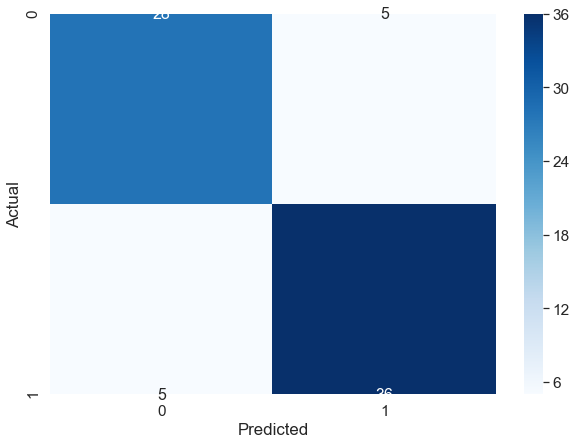

In [87]:
rf_data = confusion_matrix(y_test, rf3.predict(X_test))

rf_cm = pd.DataFrame(rf_data, columns=np.unique(y_test), index = np.unique(y_test))
rf_cm.index.name = 'Actual'
rf_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(rf_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Pre-processing effects

Evaluated differences between scaled and non-scaled data.
Non-scaled performs better persumable due to the differences in values between the features tip and total_bill that exhibit the highest correlation.

## Parameter Tuning

Using GridSearchCV to define the desired parameter search space and try all possible combinations is a really nice feature and eases the parameter tuning process.


The difficulty comes when looking through all possible parameter values for some models as certain combinations do not work together well or do not make much sense.


The results seem to show that the GridSearchCV does indeed return parameters for the model that do improve the performance for the classiciation task.

## Conclusion

Non-scaled:

* LogisticRegression: 0.958824 ⇒ 0.9594594594594594 <span style="font-weight:bold;color:green">(+)</span>
* GradientDescent: 0.841176 ⇒ 0.9594594594594594 <span style="font-weight:bold;color:green">(+)</span>
* DecisionTree: 0.858824 ⇒ 0.8513513513513513 <span style="font-weight:bold;color:red">(-)</span>
* RandomForest: 0.847059 ⇒  0.8648648648648649 <span style="font-weight:bold;color:green">(+)</span>
        
Scaled:

* LogisticRegression: 0.941176 ⇒ 0.8783783783783784 <span style="font-weight:bold;color:red">(-)</span>
* GradientDescent: 0.941176 ⇒ 0.8918918918918919 <span style="font-weight:bold;color:red">(-)</span>
* DecisionTree: 0.864706 ⇒ 0.8378378378378378 <span style="font-weight:bold;color:red">(-)</span>
* RandomForest: 0.823529 ⇒ 0.8513513513513513 <span style="font-weight:bold;color:green">(+)</span>